In [3]:
import pickle
import sys
import numpy as np
import pandas as pd
import artm
import seaborn as sns
import matplotlib.pyplot as plt
print artm.version()

from os import path, mkdir
from datetime import datetime
sys.path.insert(0, '..\\modules\\helpers')
import distances_helper as dh 
from plot_helper import PlotMaker
from config_helper import ConfigPaths
from print_helper import PrintHelper
from sklearn.decomposition import PCA
from scipy.spatial import ConvexHull
from scipy.optimize import minimize
from sklearn.metrics.pairwise import cosine_distances
from numpy.linalg import norm as euclidean_norm

0.8.1


In [4]:
config = ConfigPaths('config.cfg')
plot_maker = PlotMaker()
printer = PrintHelper()
print config.models_file_name

Q:\\topic_modeling\\csi_science_collections.git\experiments\UCI_filtered_ngramm_trimmed_without_names\np_19_12\models.txt


In [5]:
models_file = open(config.models_file_name, 'a')

In [6]:
def create_model(current_dictionary, n_topics, n_doc_passes, seed_value, n_top_tokens, p_mass_threshold):    
    print '[{}] creating model'.format(datetime.now())
    model = artm.ARTM(num_topics=n_topics, dictionary=current_dictionary, cache_theta=True, seed=seed_value, 
                  class_ids={'ngramm': 1.0, 'author_id': 0.0, 'author': 0.0, 
                             'post_tag': 0.0, 'projects': 0.0, 'category': 0.0,
                             'following_users': 0.0})
    model.num_document_passes = n_doc_passes
    add_scores_to_model(model, n_top_tokens=n_top_tokens, p_mass_threshold=p_mass_threshold)
    return model
def add_scores_to_model(artm_model, n_top_tokens, p_mass_threshold):
    print '[{}] adding scores'.format(datetime.now())
    artm_model.scores.add(artm.PerplexityScore(name='perplexity_score',
                                      dictionary=dictionary))
    artm_model.scores.add(artm.SparsityPhiScore(name='sparsity_phi_score', class_id='ngramm'))
    artm_model.scores.add(artm.SparsityThetaScore(name='sparsity_theta_score'))
    artm_model.scores.add(artm.TopicKernelScore(name='topic_kernel_score', class_id='ngramm', 
                                                probability_mass_threshold=p_mass_threshold))
    artm_model.scores.add(artm.TopTokensScore(name='top_tokens_score', class_id='ngramm', num_tokens=n_top_tokens))
def fit_one_model(model, _n_iterations, _model_name=''): 
    print '[{}] fitting'.format(datetime.now())
    model.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=_n_iterations)
    print '[{}] outputting'.format(datetime.now())
    printer.print_artm_model(model, _model_name, _n_iterations, output_file=models_file)
    model_pics_file_name =  path.join(config.experiment_path, _model_name)
    plot_maker.make_tm_plots(model, model_pics_file_name)
    model_output_file_name = path.join(config.experiment_path, _model_name + '.txt')
    printer.print_scores(model, _model_name, _n_iterations, model_output_file_name)
    printer.print_top_tokens(model, model_output_file_name)
    return model
def save_pickle_file(dists, filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'wb')
    pickle.dump(dists, pickle_file)
    pickle_file.close()
def load_pickle_file(filename):
    pickle_filename = path.join(config.experiment_path, filename)
    pickle_file = open(pickle_filename, 'rb')
    p_file = pickle.load(pickle_file)
    pickle_file.close()
    return p_file
def save_model_pickle(_model_name, _model, _save=True):
    phi = _model.get_phi()
    phi = phi[(phi.T != 0).any()]
    theta = _model.get_theta()    
    saved_top_tokens = _model.score_tracker['top_tokens_score'].last_tokens
    if _save:
        save_pickle_file(phi, 'phi_{}.p'.format(_model_name))
        save_pickle_file(theta, 'theta_{}.p'.format(_model_name))
        save_pickle_file(saved_top_tokens, 'saved_top_tokens_{}.p'.format(_model_name))
    return phi, theta, saved_top_tokens
def load_model_pickle(_model_name, _distance_name):
    phi = load_pickle_file('phi_{}.p'.format(_model_name))
    theta = load_pickle_file('theta_{}.p'.format(_model_name))
    saved_top_tokens = load_pickle_file('saved_top_tokens_{}.p'.format(_model_name))
    distances = load_pickle_file('{}.p'.format(_distance_name))
    return phi, theta, saved_top_tokens, distances

In [7]:
batch_vectorizer = artm.BatchVectorizer(data_path=config.output_batches_path,
                                        data_format='batches')
dictionary = artm.Dictionary()
dictionary.load(dictionary_path=config.dictionary_path + '.dict')

In [8]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_1')
model1 = tmp_model; tmp_model = None

[2016-12-20 23:45:47.528000] creating model
[2016-12-20 23:45:49.223000] adding scores
[2016-12-20 23:45:49.229000] fitting
[2016-12-20 23:46:45.407000] outputting
name = model_100_1, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25



In [9]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.1
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.05
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_2')
model2 = tmp_model; tmp_model = None

[2016-12-20 23:47:11.195000] creating model
[2016-12-20 23:47:12.799000] adding scores
[2016-12-20 23:47:12.899000] fitting
[2016-12-20 23:48:13.317000] outputting
name = model_100_2, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.1
decorrelator_phi_regularizer, tau = 100
ss_phi_regularizer, tau = -0.05



In [12]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.2
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.1
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_3')

[2016-12-21 00:19:52.458000] creating model
[2016-12-21 00:19:54.451000] adding scores
[2016-12-21 00:19:54.466000] fitting
[2016-12-21 00:20:36.358000] outputting
name = model_100_3, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.2
decorrelator_phi_regularizer, tau = 100
ss_phi_regularizer, tau = -0.1



In [13]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1000
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.3
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.2
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_4')

[2016-12-21 00:26:37.765000] creating model
[2016-12-21 00:26:39.217000] adding scores
[2016-12-21 00:26:39.266000] fitting
[2016-12-21 00:27:22.283000] outputting
name = model_100_4, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.3
decorrelator_phi_regularizer, tau = 1000
ss_phi_regularizer, tau = -0.2



In [14]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1000
tmp_model.regularizers['ss_theta_regularizer'].tau = -0.5
tmp_model.regularizers['ss_phi_regularizer'].tau = -0.5
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_5')

[2016-12-21 00:47:46.115000] creating model
[2016-12-21 00:48:00.636000] adding scores
[2016-12-21 00:48:01.305000] fitting
[2016-12-21 00:49:39.164000] outputting
name = model_100_5, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -0.5
decorrelator_phi_regularizer, tau = 1000
ss_phi_regularizer, tau = -0.5



In [15]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 1000
tmp_model.regularizers['ss_theta_regularizer'].tau = -1
tmp_model.regularizers['ss_phi_regularizer'].tau = -1
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_6')

[2016-12-21 01:59:53.081000] creating model
[2016-12-21 02:00:15.179000] adding scores
[2016-12-21 02:00:18.596000] fitting
[2016-12-21 02:00:48.104000] outputting
name = model_100_6, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -1
decorrelator_phi_regularizer, tau = 1000
ss_phi_regularizer, tau = -1



In [16]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 100
tmp_model.regularizers['ss_theta_regularizer'].tau = -1
tmp_model.regularizers['ss_phi_regularizer'].tau = -1
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_7')

[2016-12-21 02:03:11.721000] creating model
[2016-12-21 02:03:13.063000] adding scores
[2016-12-21 02:03:13.179000] fitting
[2016-12-21 02:03:43.816000] outputting
name = model_100_7, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -1
decorrelator_phi_regularizer, tau = 100
ss_phi_regularizer, tau = -1



In [17]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 10
tmp_model.regularizers['ss_theta_regularizer'].tau = -1
tmp_model.regularizers['ss_phi_regularizer'].tau = -1
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_8')

[2016-12-21 02:05:08.875000] creating model
[2016-12-21 02:05:10.004000] adding scores
[2016-12-21 02:05:10.104000] fitting
[2016-12-21 02:05:40.387000] outputting
name = model_100_8, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -1
decorrelator_phi_regularizer, tau = 10
ss_phi_regularizer, tau = -1



In [ ]:
# top words better

In [18]:
tmp_model = create_model(current_dictionary=dictionary, n_topics=100, n_doc_passes=5, seed_value=100,
                            n_top_tokens=15, p_mass_threshold=0.25)
tmp_model.regularizers.add(artm.DecorrelatorPhiRegularizer(name='decorrelator_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers.add(artm.SmoothSparseThetaRegularizer(name='ss_theta_regularizer'))
tmp_model.regularizers.add(artm.SmoothSparsePhiRegularizer(name='ss_phi_regularizer', class_ids=['ngramm']))
tmp_model.regularizers['decorrelator_phi_regularizer'].tau = 5
tmp_model.regularizers['ss_theta_regularizer'].tau = -1
tmp_model.regularizers['ss_phi_regularizer'].tau = -1
tmp_model = fit_one_model(tmp_model, _n_iterations=20, _model_name='model_100_9')

[2016-12-21 02:08:47.555000] creating model
[2016-12-21 02:08:48.741000] adding scores
[2016-12-21 02:08:48.825000] fitting
[2016-12-21 02:09:21.410000] outputting
name = model_100_9, n_topics = 100, n_doc_passes = 5, seed_value = 100, n_iterations = 20, n_top_tokens = 15, p_threshold = 0.25
ss_theta_regularizer, tau = -1
decorrelator_phi_regularizer, tau = 5
ss_phi_regularizer, tau = -1



In [20]:
model9 = tmp_model

In [19]:
def calculate_distances(dist_fun, _phi, _phi_other):
    print '[{}] take_distances between {} columns and {} columns'.format(datetime.now(), len(_phi.columns), len(_phi_other.columns))
    distances = pd.DataFrame(0, index = _phi.columns, columns=_phi_other.columns)
    for idx, col in enumerate(_phi.columns):
        print '[{}] column num {} of {}'.format(datetime.now(), idx, len(_phi.columns))
        for idx_other, col_other in enumerate(_phi_other.columns):
            distance = dist_fun(_phi[col], _phi_other[col_other])
            distances.iloc[idx, idx_other] = distance
    return distances
def get_optimization_result_one_matrix(dist_fn, jac_dist_fn, phi, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)
        column = phi[col_name]
        # delete col from phi
        phi_cut = phi.drop(col_name, axis=1)
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, col_name, phi_cut, distances)
    return opt_results
def get_optimization_result(dist_fn, jac_dist_fn, phi, phi_other, distances):
    opt_results = {}
    for col_idx, col_name in enumerate(phi.columns):
        print '[{}] get_optimization_result for column {}'.format(datetime.now(), col_idx)        
        column = phi[col_name]
        opt_results[col_name] = solve_optimization_problem(dist_fn, jac_dist_fn, column, column_name, phi_other, distances)
    return opt_results
def solve_optimization_problem(dist_fn, jac_dist_fn, column, column_name, phi, distances, verbose=False):
    max_iter = 50
    phi_columns = phi.columns
    # cut distances by phi columns 
    cut_distances = distances.loc[phi_columns]
    # get n closest topics
    closest_column_names = cut_distances[column_name].sort_values().head(N_CLOSEST_TOPICS).index.values
    phi_closest = phi[closest_column_names]
    
    # opt solver
    n_columns = phi_closest.shape[1] 
    bnds = [(0, 1)] * n_columns
    constraints = cons = ({'type': 'eq', 'fun': lambda x:  np.sum(x) - 1, 'jac': lambda x: [1] * n_columns})
    opt_fun = lambda x: dist_fn(column, phi_closest.dot(x))
    jac_fun = lambda x: jac_dist_fn(column, phi_closest, x)
    
    is_optimized = False
    it = 0
    while (not is_optimized) and it != 4:
        it += 1
        init_x = np.random.uniform(0, 1, (1, n_columns))
        init_x /= np.sum(init_x)
        if jac_dist_fn is not None:
            res = minimize(opt_fun, jac=jac_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        else:
            res = minimize(opt_fun, x0=init_x, method='SLSQP', bounds=bnds, constraints=cons, options={'maxiter': max_iter, 'disp': verbose})
        is_optimized = res.success
    if not is_optimized:
        print 'Not optimized' 
    res['column_names'] = phi_closest.columns
    res['optimized_column'] = column_name
    return res

In [21]:
phi1, theta1, saved_top_tokens1 = save_model_pickle('model_100_9', model9)
distances_hellinger_model1 = calculate_distances(dh.hellinger_dist, phi1, phi1)
save_pickle_file(distances_hellinger_model1, 'distances_hellinger_model_100_9.p')

[2016-12-21 02:23:32.992000] take_distances between 100 columns and 100 columns
[2016-12-21 02:23:33.008000] column num 0 of 100
[2016-12-21 02:23:33.233000] column num 1 of 100
[2016-12-21 02:23:33.340000] column num 2 of 100
[2016-12-21 02:23:33.450000] column num 3 of 100
[2016-12-21 02:23:33.545000] column num 4 of 100
[2016-12-21 02:23:33.640000] column num 5 of 100
[2016-12-21 02:23:33.749000] column num 6 of 100
[2016-12-21 02:23:33.871000] column num 7 of 100
[2016-12-21 02:23:34.028000] column num 8 of 100
[2016-12-21 02:23:34.125000] column num 9 of 100
[2016-12-21 02:23:34.209000] column num 10 of 100
[2016-12-21 02:23:34.325000] column num 11 of 100
[2016-12-21 02:23:34.425000] column num 12 of 100
[2016-12-21 02:23:34.586000] column num 13 of 100
[2016-12-21 02:23:34.680000] column num 14 of 100
[2016-12-21 02:23:34.773000] column num 15 of 100
[2016-12-21 02:23:34.884000] column num 16 of 100
[2016-12-21 02:23:34.957000] column num 17 of 100
[2016-12-21 02:23:35.058000] c

In [6]:
phi1, theta1, saved_top_tokens1, distances_hellinger_model1 = load_model_pickle('model_100_9', 'distances_hellinger_model_100_9')

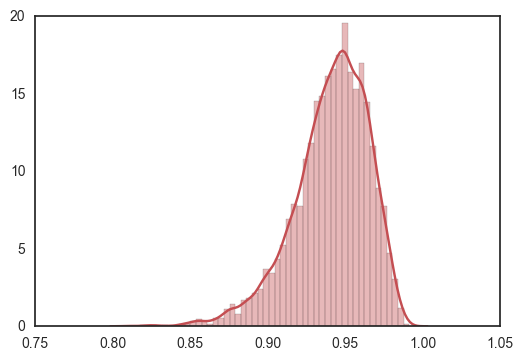

In [22]:
# построим распределение полученных distances
%matplotlib inline
vals = distances_hellinger_model1.values.flatten()
sns.distplot(vals[vals != 0], color='r')

In [23]:
N_CLOSEST_TOPICS = 50
NUM_INDICES = 10

In [24]:
opt_res_hellinger_model1 = get_optimization_result_one_matrix(dh.hellinger_dist, None, phi1, distances_hellinger_model1)
save_pickle_file(opt_res_hellinger_model1, 'opt_res_hellinger_model_100_9.p')

[2016-12-21 02:24:47.283000] get_optimization_result for column 0
[2016-12-21 02:24:51.858000] get_optimization_result for column 1
[2016-12-21 02:24:52.349000] get_optimization_result for column 2
[2016-12-21 02:24:56.336000] get_optimization_result for column 3
[2016-12-21 02:25:00.741000] get_optimization_result for column 4
[2016-12-21 02:25:03.642000] get_optimization_result for column 5
[2016-12-21 02:25:07.200000] get_optimization_result for column 6
[2016-12-21 02:25:13.073000] get_optimization_result for column 7
[2016-12-21 02:25:16.938000] get_optimization_result for column 8
[2016-12-21 02:25:19.792000] get_optimization_result for column 9
[2016-12-21 02:25:23.440000] get_optimization_result for column 10
[2016-12-21 02:25:27.462000] get_optimization_result for column 11
[2016-12-21 02:25:31.209000] get_optimization_result for column 12
[2016-12-21 02:25:35.546000] get_optimization_result for column 13
[2016-12-21 02:25:38.220000] get_optimization_result for column 14
[2016

In [14]:
opt_res_hellinger_model1 = load_pickle_file('opt_res_hellinger_model_100_9.p')

In [ ]:
# построим распределение полученных opt_fun 

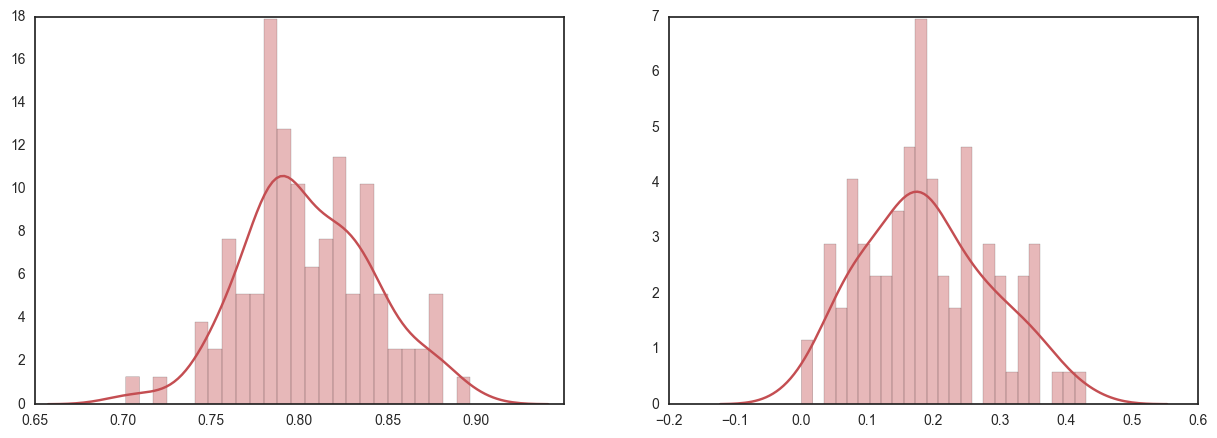

In [28]:
%matplotlib inline
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, figsize=(15,5))
sns.distplot([val.fun for val in opt_res_hellinger_model1.itervalues()], color='r', bins=25, ax=ax1)
sns.distplot([val.x[0] for val in opt_res_hellinger_model1.itervalues()], color='r', bins=25, ax=ax2)

In [26]:
models_file.close()